# XGBOOST

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import auc
from matplotlib import pyplot as plt

%matplotlib inline


pd.set_option('display.max_columns', None)

/Users/rezarad/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Import Dataset

In [3]:
df = pd.read_csv('../EDA/merged_w_state_build_2017-05-30.csv',  parse_dates=['timestamp'], index_col=False, low_memory=False)

### Select Features

In [9]:
features = ['floor', 'full_sq^2', 'area_km', 'density','month','year','age_log',
            'rel_floor', 'material', 'num_room', 'work_share','kitch_sq', 'state', 'product_type',
            'sub_area', 'indust_part', 'sport_objects_raion', 'metro_min_avto',
            'green_zone_km', 'industrial_km', 'kremlin_km', 'radiation_km', 'ts_km', 'fitness_km',
            'stadium_km', 'park_km', 'price_doc_log']

In [10]:
np.sum(df['price_doc_log'].isnull())

7662

### Transform some Features

In [11]:
np.sum(df['full_sq^2'].isnull())

49

In [15]:
for feature in features:
    if np.sum(df[feature].isnull()) > 0:
        print feature,np.sum(df[feature].isnull())

price_doc_log 7662


In [14]:
df['age_log'] = np.log1p(df['age'])
df.loc[df['full_sq^2'].isnull(), 'full_sq^2'] = np.median(df.loc[df['full_sq^2'].notnull(),'full_sq^2'])
df.loc[df['rel_floor'].isnull(), 'rel_floor'] = np.median(df.loc[df['rel_floor'].notnull(),'rel_floor'])

In [16]:
df.shape

(37659, 458)

### Split into two dataframes

In [17]:
train_df = df.loc[df['price_doc_log'].notnull()]
test_df = df.loc[df['price_doc_log'].isnull()]

In [18]:
# value from splitting by price ipynb
split_value = 11000000

In [21]:
df_lower = df.loc[df['price_doc'] < split_value]
df_upper = df.loc[df['price_doc'] > split_value]

In [23]:
df_lower.shape, df_upper.shape

((26338, 458), (3526, 458))

### Lower Priced Homes

In [46]:
df_lower = df_lower.select_dtypes(exclude=['datetime'])
df_lower = df_lower[features]

y_train_l = df_lower.loc[df_lower['price_doc_log'].notnull(), 'price_doc_log']
X_train_l = df_lower.loc[df_lower['price_doc_log'].notnull(), df_lower.columns != 'price_doc_log']
X_test_l = df_lower.loc[df_lower['price_doc_log'].isnull(), df_lower.columns != 'price_doc_log']

print y_train_l.shape, X_train_l.shape, X_test_l.shape

(29997,) (29997, 26) (7662, 26)


### Higher Priced Homes

In [26]:
df_upper = df_upper.select_dtypes(exclude=['datetime'])
df_upper = df_upper[features]

y_train_l = df_upper.loc[df_upper['price_doc_log'].notnull(), 'price_doc_log']
X_train_l = df_upper.loc[df_upper['price_doc_log'].notnull(), df_upper.columns != 'price_doc_log']
X_test_l = df_upper.loc[df_upper['price_doc_log'].isnull(), df_upper.columns != 'price_doc_log']

print y_train_l.shape, X_train_l.shape, X_test_l.shape

(3526,) (3526, 26) (0, 26)


Lets run xgboost using only homes in the bottom 95% of our price distribution

## Selecting Features

In [47]:
import xgboost as xgb

xgb_params = {
    'eta': 0.02,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train_l, y_train_l, feature_names=X_train_l.columns)
dtest = xgb.DMatrix(X_test_l, feature_names=X_test_l.columns)


cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, 
                   early_stopping_rounds=20, verbose_eval=True, show_stdv=False)

[0]	train-rmse:14.8171	test-rmse:14.8172
[1]	train-rmse:14.5213	test-rmse:14.5213
[2]	train-rmse:14.2313	test-rmse:14.2313
[3]	train-rmse:13.9472	test-rmse:13.9472
[4]	train-rmse:13.6687	test-rmse:13.6688
[5]	train-rmse:13.3959	test-rmse:13.3959
[6]	train-rmse:13.1285	test-rmse:13.1285
[7]	train-rmse:12.8664	test-rmse:12.8665
[8]	train-rmse:12.6096	test-rmse:12.6097
[9]	train-rmse:12.358	test-rmse:12.358
[10]	train-rmse:12.1114	test-rmse:12.1114
[11]	train-rmse:11.8697	test-rmse:11.8697
[12]	train-rmse:11.6328	test-rmse:11.6328
[13]	train-rmse:11.4008	test-rmse:11.4008
[14]	train-rmse:11.1733	test-rmse:11.1733
[15]	train-rmse:10.9505	test-rmse:10.9505
[16]	train-rmse:10.732	test-rmse:10.732
[17]	train-rmse:10.5179	test-rmse:10.5179
[18]	train-rmse:10.3082	test-rmse:10.3082
[19]	train-rmse:10.1027	test-rmse:10.1027
[20]	train-rmse:9.9012	test-rmse:9.90121
[21]	train-rmse:9.70377	test-rmse:9.7038
[22]	train-rmse:9.51027	test-rmse:9.51031
[23]	train-rmse:9.32073	test-rmse:9.32079
[24]	tra

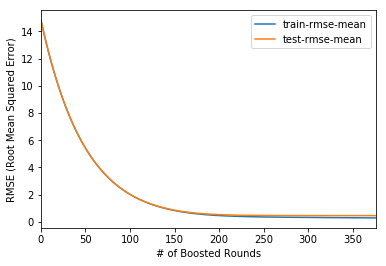

In [48]:
plt.figure(figsize=(14,4),dpi=80)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.xlabel('# of Boosted Rounds')
plt.ylabel('RMSE (Root Mean Squared Error)')
plt.show()

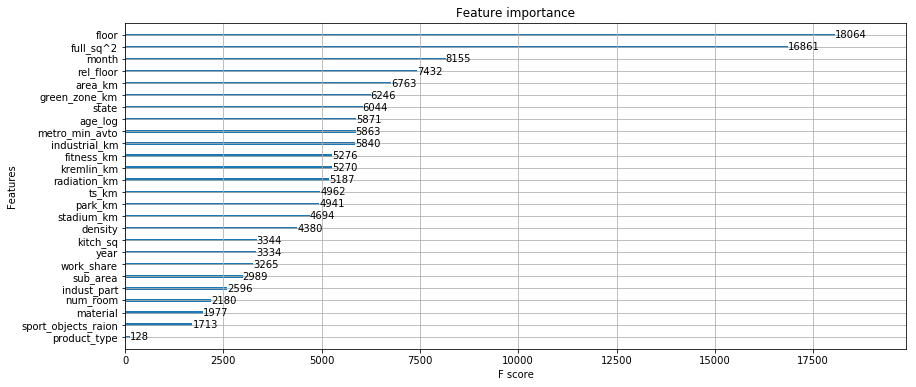

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
xgb.plot_importance(model, height=0.2, ax=ax)

In [50]:
num_boost_round = 819

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

In [54]:
y_pred = model.predict(dtest)

In [55]:
y_pred

array([ 15.47372913,  15.99097443,  15.41759109, ...,  15.38066578,
        15.49134064,  16.09592628], dtype=float32)

In [56]:
y_test = np.expm1(y_pred)

In [57]:
y_test

array([ 5249949. ,  8806268. ,  4963347. , ...,  4783416.5,  5343227.5,
        9780745. ], dtype=float32)

In [58]:
sample = pd.read_csv('../sample_submission.csv', index_col=False)

sample.head(10)

,id,price_doc
0,30474,7118500.41
1,30475,7118500.41
2,30476,7118500.41
3,30477,7118500.41
4,30478,7118500.41
5,30479,7118500.41
6,30480,7118500.41
7,30481,7118500.41
8,30482,7118500.41
9,30483,7118500.41


In [59]:
sample['price_doc'] = y_test

In [60]:
sample.to_csv('./xgboost_lowsplit_053017.csv', index=False)